## 0. Library Imports

In [1]:
import tensorflow as tf   
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, ZeroPadding2D
from keras.layers import AveragePooling2D, MaxPooling2D, Flatten, Add
from keras.models import Model 
from keras.regularizers import l2

import os
import matplotlib.pyplot as plt
from modules import create_dataset_csv
from modules import download_images

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.gpu_device_name()

Num GPUs Available:  1


'/device:GPU:0'

## 1. Generating a Dataset

In [3]:
image_size = (256, 256)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.getcwd()+"/data_dump/datasets/ds_test",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.getcwd()+"/data_dump/datasets/ds_test",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 88468 files belonging to 2 classes.
Using 70775 files for training.
Found 88468 files belonging to 2 classes.
Using 17693 files for validation.


### Visualize the data

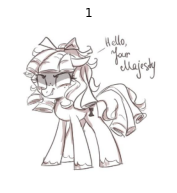

In [6]:
plt.figure(figsize=(3, 3))
for images, labels in train_ds.take(1):
    plt.imshow(images[0].numpy().astype("uint8").squeeze())
    plt.title(int(labels[0]))
    plt.axis("off")

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.4,-0.4)),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

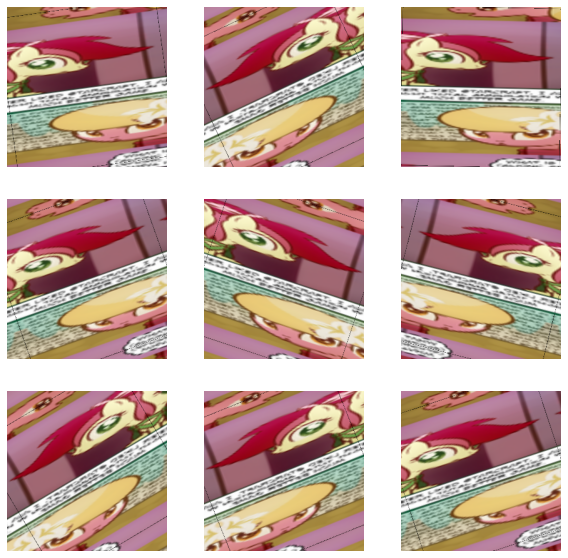

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8").squeeze())
        plt.axis("off")

## 4. Building A Model

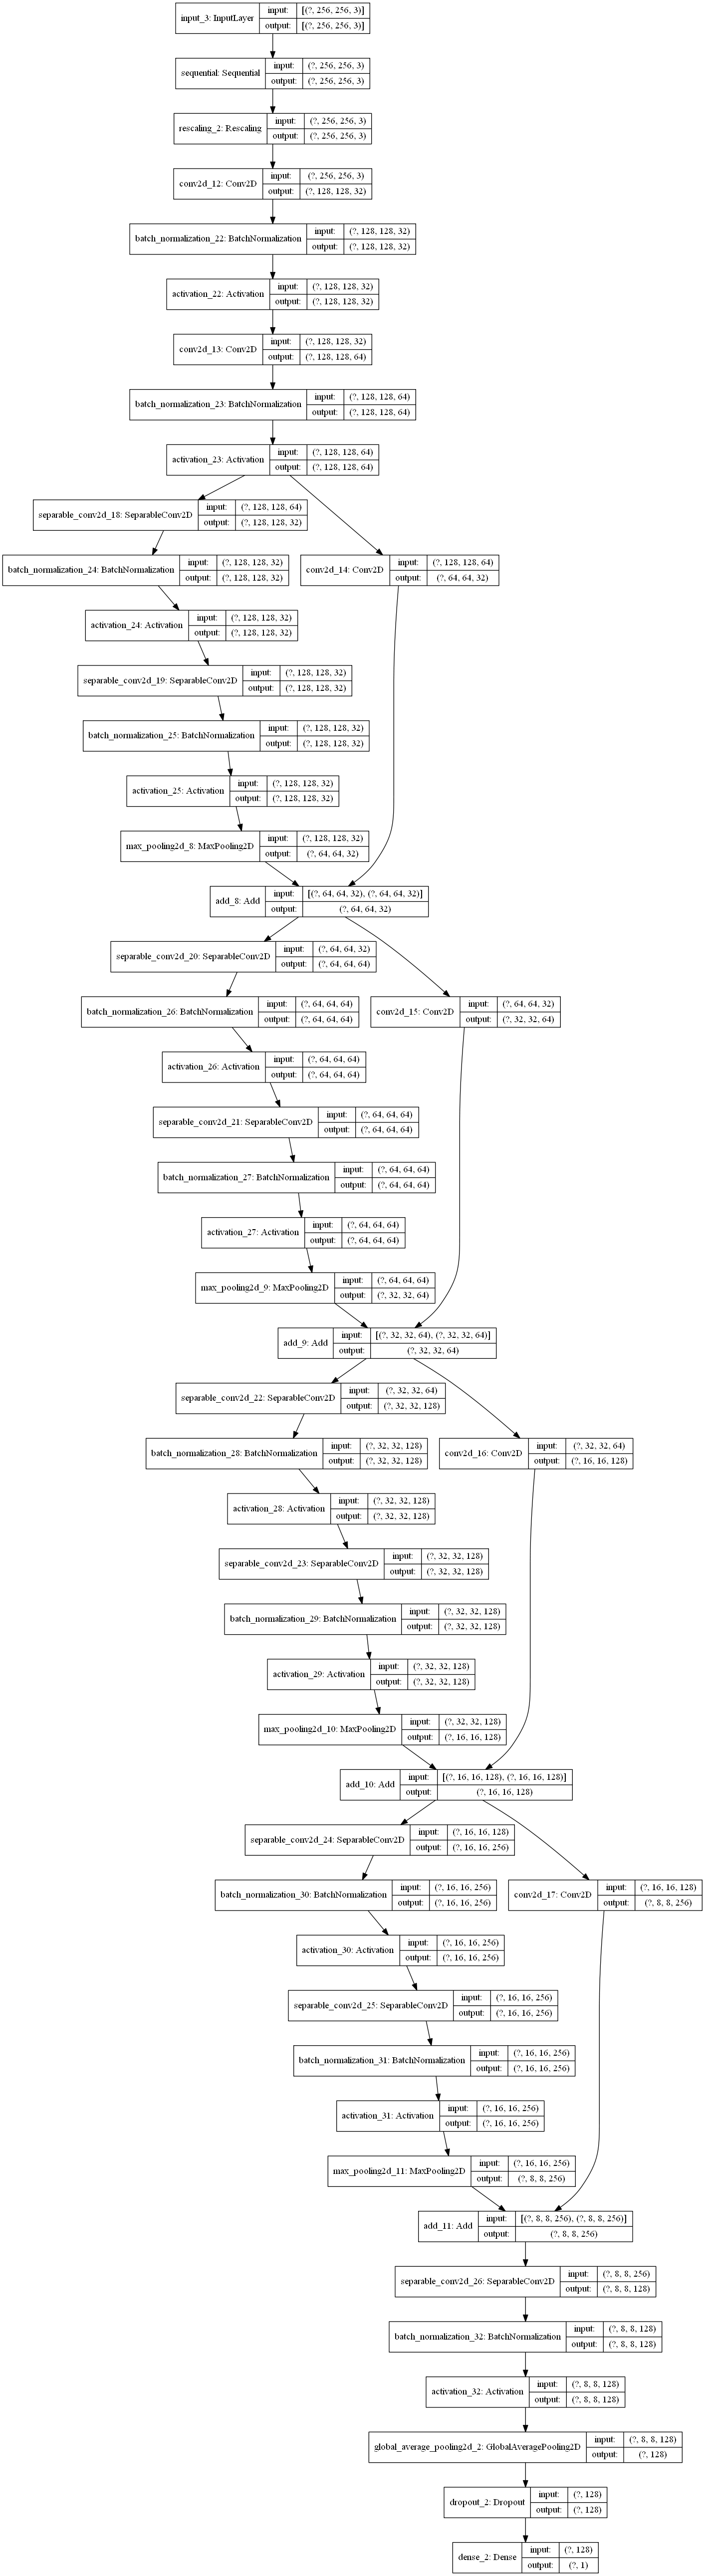

In [22]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = Conv2D(32, kernel_size=(3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(64, kernel_size=(3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [32, 64, 128, 256]:
        
        x = layers.SeparableConv2D(size, kernel_size=(3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = layers.SeparableConv2D(size, kernel_size=(3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = MaxPooling2D((3, 3), strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(size, kernel_size=(1, 1), strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(128, kernel_size=(3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

## 5. Training and Testing at 1 Epoch (Testing the model architecture)

In [20]:
# Trained with softmax rather than sigmoid

epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

4424/4424 [==============================] - 2887s 653ms/step - loss: 0.6931 - accuracy: 0.5046 - val_loss: 0.6932 - val_accuracy: 0.4732


In [10]:
target_database_folder = "D:/repositories/MLpy/data_dump/datasets/ds_test/test_data_1_epoch/"
if not os.path.exists(target_database_folder): os.makedirs(target_database_folder)
    
class1_tags = ["explicit","grotesque","questionable"]
class2_tags = ["safe"]

path_class1 = create_dataset_csv(class1_tags, 1, target_database_folder)
path_class2 = create_dataset_csv(class2_tags, 1, target_database_folder)

{'retrieve tag id': "SELECT id FROM new_tags WHERE name IN ('explicit','grotesque','questionable');"}
COPY (SELECT id, image_format, version_path FROM new_images WHERE id IN (SELECT image_id FROM new_image_taggings WHERE tag_id IN ('39068','29300','26707')) ORDER BY RANDOM() LIMIT 1) TO 'D:/repositories/MLpy/data_dump/datasets/ds_test/test_data_1_epoch/39068_29300_26707.csv' DELIMITER '|' CSV;
{'retrieve tag id': "SELECT id FROM new_tags WHERE name IN ('safe');"}
COPY (SELECT id, image_format, version_path FROM new_images WHERE id IN (SELECT image_id FROM new_image_taggings WHERE tag_id IN ('40482')) ORDER BY RANDOM() LIMIT 1) TO 'D:/repositories/MLpy/data_dump/datasets/ds_test/test_data_1_epoch/40482.csv' DELIMITER '|' CSV;


In [11]:
download_images(target_database_folder, path_class1)

#1 sent - #1 image downloaded - #0 errors caught so far.


In [12]:
download_images(target_database_folder, path_class2)

#1 sent - #1 image downloaded - #0 errors caught so far.


In [21]:
img = keras.preprocessing.image.load_img(target_database_folder+"39068_29300_26707/2385838.png", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent class 0 and %.2f percent class 1."
    % (100 * (1 - score), 100 * score)
)

img = keras.preprocessing.image.load_img(target_database_folder+"40482/1747984.png", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent class 0 and %.2f percent class 1."
    % (100 * (1 - score), 100 * score)
)

TypeError: only size-1 arrays can be converted to Python scalars

## 6. Training and Testing at 50 Epochs

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

In [ ]:
target_database_folder = "D:/repositories/MLpy/data_dump/datasets/ds_test/test_data/"
if not os.path.exists(target_database_folder): os.makedirs(target_database_folder)
    
class1_tags = ["explicit","grotesque","questionable"]
class2_tags = ["safe"]

path_class1 = create_dataset_csv(class1_tags, 1000, target_database_folder)
path_class2 = create_dataset_csv(class2_tags, 1000, target_database_folder)

In [ ]:
download_images(target_database_folder, path_class1)

In [ ]:
download_images(target_database_folder, path_class2)